# Прикладные задачи анализа данных


В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [857]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [858]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [859]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$\large
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$\large
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$\large p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

In [860]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    apak = np.array([])
    for user, rel in enumerate(relevant):
        
        relset = set(rel)
        predset = set(predicted[user][:k])
        r = len(predset & relset)
        
        sumk = 0
        for k_ in range(k):
            if predicted[user][k_] in relset:
                predset_ = set(predicted[user][:k_ + 1])
                sumk += (len(predset_ & relset) / (k_ + 1))
        apak = np.append(apak, sumk / min(k, len(rel)))
    
    return np.mean(apak)

In [861]:
relevant2 = [
    [1, 2],
    [5, 6],
    [2, 4]
]

pred2 = [
    [1, 2, 3, 4, 5, 6],
    [1, 2, 3, 4, 5, 6],
    [1, 2, 3, 4, 5, 6]
]

mapk(relevant2, pred2, k=6)

0.5888888888888889

In [862]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

mapk(relevant, pred, k=5)

0.4330555555555555

In [863]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [864]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [865]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [866]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [867]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [868]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [869]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [870]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [871]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

In [872]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self):
        test_preds = []
        
        for u, known in enumerate(self.R):
            pred = self.recommend(u) - known
            #pred[pred < 0 ] = 0 
            
            test_preds.append(pred)
        
        return test_preds

## Часть 1. Коллаборативная фильтрация (User2User)

In [873]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    R = ratings
    
    numerator = np.sum(user_vector * R, axis=1)
    denominator = np.sqrt(np.sum(user_vector)) * np.sqrt(np.sum(R, axis=1))
    pearson_corr_vec = numerator / denominator
    
    return pearson_corr_vec.reshape(-1, 1)[:, 0]



def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    R = ratings
    
    numerator = np.sum(user_vector * R, axis=1)
    denominator = np.count_nonzero(R + user_vector, axis=1)    
    jaccard_index_vec = numerator / denominator
        
    return jaccard_index_vec.reshape(-1, 1)[:, 0]

In [874]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        sim_vec = self.similarity_func(self.R, user_vector)
        sim_vec[sim_vec < self.alpha] = 0
        sim_vec[sim_vec == 1] = np.exp(-15) # ~ 0.
        
        return sim_vec
        
    
    def recommend(self, uid: int):
        R = self.R
        sim_vec = self.similarity(R[uid, :])
        r_hat_vec = np.sum((sim_vec * R.T).T, axis=0) / abs(sim_vec).sum()
        
        return np.argsort(-r_hat_vec)

In [875]:
r_hat_rand = []

for user in range(test_ratings['userId'].max() + 1):
    np.random.seed(user)
    
    unique = test_ratings['trackId'].unique()
    
    np.random.shuffle(unique)
    r_hat_rand.append(unique)

In [876]:
user2user_p = User2User(train_ratings, pearson)
user2user_j = User2User(train_ratings, jaccard)

r_hat_p = user2user_p.get_test_recommendations()
r_hat_j = user2user_j.get_test_recommendations()

In [877]:
mapk_p = []
mapk_j = []
mapk_rand = []

for k in range(1, 31):
    mapk_p.append(mapk(test_relevant, r_hat_p, k))
    mapk_j.append(mapk(test_relevant, r_hat_j, k))
    mapk_rand.append(mapk(test_relevant, r_hat_rand, k))

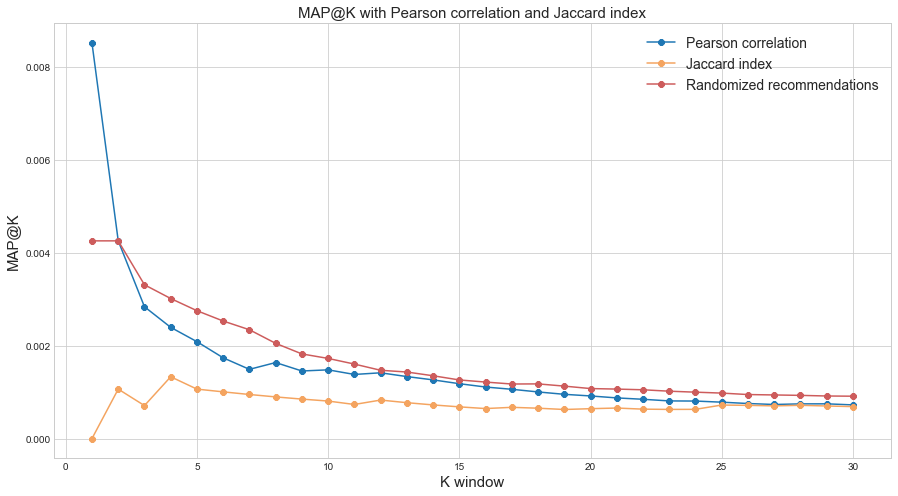

In [878]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = [15, 8])

plt.plot(list(range(1, 31)), mapk_p, marker = '8', label='Pearson correlation')
plt.plot(list(range(1, 31)), mapk_j, marker = '8', color='sandybrown', label='Jaccard index')
plt.plot(list(range(1, 31)), mapk_rand, marker = '8', color='indianred', label='Randomized recommendations')

plt.title('MAP@K with Pearson correlation and Jaccard index', fontsize=15)
plt.xlabel('K window', fontsize = 15)
plt.ylabel('MAP@K', fontsize = 15)

plt.legend(fontsize=14)

Наш алгоритм (на основе корреляции Пирсона и индекса Жаккара) не сильно лучше алгоритма с рандомизирвоанными рекомендациями. Это может быть связано с тем, что пользователи имеют очень мало общего и поэтому, основанные на их похожести, рекомендации несут в себе смысла не больше, чем рандомные предсказания.

Также, мера Жаккара на малых размерах k показывает себя хуже, однако, с б**о**льшим k качество алгоритмо сравнивается.

Случайный и на основе корреляции Пирсона алгоритмы показывают ухудшающееся при росте k качество прогнозов. В случае корреляции Пирсона это можно объяснить чувствительностью к выбросам: корреляция задаст очень большой вес индивиду, похожему на искомого и потому, прослушанные им треки, встанут в начало списка рекоммендаций, как следствие, эти треки, находясь в окне малого k, и дают б**о**льший результат.

In [879]:
class ScsBaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = scs.csr_matrix((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] += 1
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self):
        test_preds = []
        
        for u, known in enumerate(self.R):
            pred = self.recommend(u) - known.toarray()
            #pred[pred < 0 ] = 0 
            
            test_preds.append(pred)
        
        return test_preds
    

class scsUser2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        sim_vec = self.similarity_func(self.R, user_vector)
        sim_vec[sim_vec < self.alpha] = 0
        sim_vec[sim_vec == 1] = np.exp(-15) # ~ 0.
        
        return sim_vec
        
    
    def recommend(self, uid: int):
        R = self.R
        sim_vec = self.similarity(R[uid, :])
        r_hat_vec = np.sum((sim_vec * R.T).T, axis=0) / abs(sim_vec).sum()
        
        return np.argsort(-r_hat_vec)

In [880]:
scs_u2u_p = scsUser2User(train_ratings, pearson)
scs_r_hat_p = scs_u2u_p.get_test_recommendations()

In [881]:
scs_u2u_j = scsUser2User(train_ratings, jaccard)
scs_r_hat_j = scs_u2u_j.get_test_recommendations()

In [882]:
scs_mapk_p = []
scs_mapk_j = []
mapk_rand = []

for k in range(1, 31):
    scs_mapk_p.append(mapk(test_relevant, scs_r_hat_p, k))
    scs_mapk_j.append(mapk(test_relevant, scs_r_hat_j, k))
    mapk_rand.append(mapk(test_relevant, r_hat_rand, k))

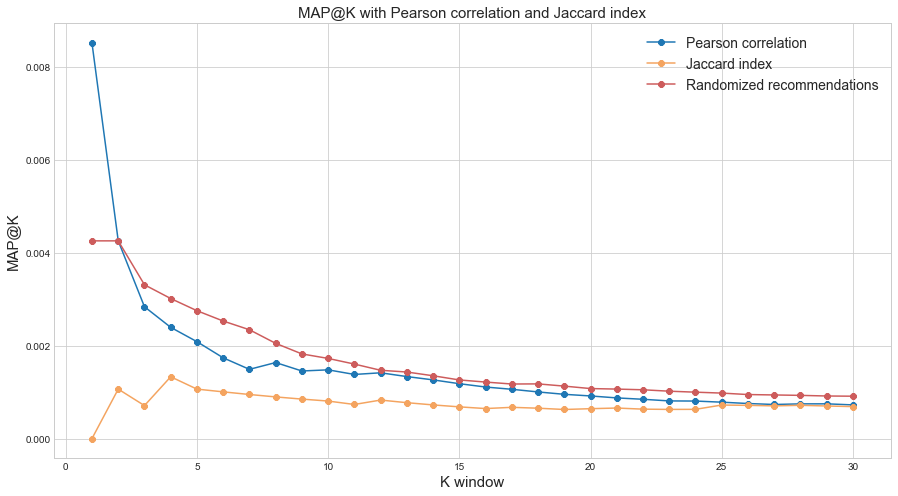

In [883]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = [15, 8])

plt.plot(list(range(1, 31)), scs_mapk_p, marker = '8', label='Pearson correlation')
plt.plot(list(range(1, 31)), scs_mapk_j, marker = '8', color='sandybrown', label='Jaccard index')
plt.plot(list(range(1, 31)), mapk_rand, marker = '8', color='indianred', label='Randomized recommendations')

plt.title('MAP@K with Pearson correlation and Jaccard index', fontsize=15)
plt.xlabel('K window', fontsize = 15)
plt.ylabel('MAP@K', fontsize = 15)

plt.legend(fontsize=14)

Я забыл вставить таймер, но могу заверить эмпирически, что работать стало быстрее, что закономерно, ведь теперь не нужно обращаться в регистр за миллионами нулей.

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [884]:
user_id = np.random.randint(0, scs_u2u_p.n_users)

In [885]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
6,Meet Me Halfway,['Black Eyed Peas']
7,I Gotta Feeling,['Black Eyed Peas']
27,La Camisa Negra,['Juanes']
282,Glamorous,"['Fergie', 'Ludacris']"
290,My Humps,['Black Eyed Peas']
302,Analogue (All I Want),['a-ha']
354,Dancing Queen,['ABBA']
410,November Rain,"[""Guns N' Roses""]"
411,Don't Cry,"[""Guns N' Roses""]"
507,Be Yourself,['Audioslave']


In [886]:
preds = np.array(scs_r_hat_p)[:, :15]

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
2814,Numb,['Linkin Park']
805,Zombie,['The Cranberries']
24500,Way Down We Go,['KALEO']
11493,The Show Must Go On,['Queen']
1073,Smells Like Teen Spirit,['Nirvana']
56031,Blinding Lights,['The Weeknd']
49576,Помнят с горечью древляне,['Король и Шут']
1018,Nemo,['Nightwish']
8263,Shape Of My Heart,['Sting']
2555,Californication,['Red Hot Chili Peppers']


In [888]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
59817,Пошлю его на...,['Дора']
60511,How You Like That,['BLACKPINK']
60666,Там ревели горы,['Miyagi & Andy Panda']
60834,Jerk,['Oliver Tree']
60941,All Of Me,"['The Score', 'Travis Barker']"
61379,Midnight Sky,['Miley Cyrus']
61626,Every Time We Touch,"['Lauren Babic', 'Cole Rolland']"
61786,When You Find Me,['plenka']
61808,Somebody Told Me,['Motionless In White']
61850,Девочка-пришелец,['ЛСП']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_i \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

Градиент характеризуется двумя уравнениями с производными по векторам-столбцам.

$$
\frac{\partial L}{\partial p_u} = 2 \sum_{(u,i)\in R} (\langle p_u, q_i \rangle-r_{u,i})q_i + 2 \lambda p_u
$$$$
\frac{\partial L}{\partial q_i} = 2 \sum_{(u,i)\in R} (\langle p_u, q_i \rangle-r_{u,i})p_u + 2 \lambda q_i
$$

Тогда, обновляя вектора-столбцы эмбеддинга по антиградиенту, получаем

**LFM:**
$$
p_u^{(t+1)} = p_u^{(t)} - \tau((\langle p_u^{(t)}, q_i^{(t)} \rangle-r_{u,i})q_i^{(t)} + \lambda p_u^{(t)})
$$
$$
q_i^{(t+1)} = q_i^{(t)} - \tau((\langle p_u^{(t)}, q_i^{(t)} \rangle-r_{u,i})p_u^{(t)} + \lambda q_i^{(t)})
$$

----------

Вновь перепишем уравнения градиента:

$$
\frac{\partial L}{\partial p_u} = 2 \sum_{(u,i)\in R} (\langle p_u, q_i \rangle-r_{u,i})q_i + 2 \lambda p_u
$$$$
\frac{\partial L}{\partial p_u} = 2 \sum_{(u,i)\in R} (\langle p_u, q_i \rangle-r_{u,i})p_u + 2 \lambda q_i
$$

**ALS:**

Так как функция потерь $L$ выпукла вниз, то необходимо и достаточно, чтобы $\large \frac{\partial L}{\partial q_i} = \frac{\partial L}{\partial p_u} = 0$. Тогда, перепишем в матричном виде:

Предположим, что $Q$ - матрица констант. 
$$
\frac{\partial L}{\partial p_u} = (p^T_u Q^t-r_u)\centerdot Q +\lambda p^T_u= 0
$$$$
\Rightarrow p_u^T(Q^TQ+\lambda I)=r_u \centerdot Q
$$
Тогда, $$
p_u^T=r_u \centerdot Q(Q^TQ + \lambda I)^{-1}
$$
Следовательно, 
$$
p_u^T=r_u \centerdot Q(Q^TQ + \lambda I)^{-1}
$$$$
q_i^T=r_i \centerdot P(P^TP + \lambda I)^{-1}
$$

Нечто в выводе формул и в коде взято из https://www.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/

In [782]:
from scipy.linalg import solve

In [836]:
class HiddenVars(ScsBaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            np.random.seed(epoch)
            if self.mode == 'sgd':
                P = self.P
                Q = self.Q
                
                row, col = self.R.nonzero()
                n = len(row)
                train_n = np.arange(n)
                np.random.shuffle(train_n)
                
                for idx in train_n:
                    u = row[idx]
                    i = col[idx]
                    
                    pred = P[u, :].dot(Q[i, :].T)
                    err = pred - self.R[u, i]
                    
                    P[u, :] -= self.lr * (err * Q[i, :] + P[u, :] * self.lamb)
                    Q[i, :] -= self.lr * (err * P[u, :] + Q[i, :] * self.lamb)
                    
                self.P = P
                self.Q = Q
                
                pass

            
            elif self.mode == 'als':
                Q = self.Q
                P = self.P
                
                QTQ = Q.T.dot(Q)
                lambdaI = scs.eye(QTQ.shape[0]) * self.lamb
                for u in range(P.shape[0]):
                    P[u, :] = solve((QTQ + lambdaI), 
                                    (self.R[u, :].dot(Q))[0])
                
                PTP = P.T.dot(P)
                lambdaI = scs.eye(PTP.shape[0]) * self.lamb
                for i in range(Q.shape[0]):
                    Q[i, :] = solve((PTP + lambdaI), 
                                    (self.R[:, i].T.dot(P))[0])
                    
                self.P = P
                self.Q = Q
                
                pass
                
    
    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

In [824]:
# ошибка пишется из-за того, что я превращаю в конце csr-матрицу в np-вектор
# это сделано для того, чтобы потом превратить вектор в список и подать в mapk
hidden_als = HiddenVars(train_ratings, mode='als')
hidden_als.fit()
hidden_r_hat_als = hidden_als.get_test_recommendations()
hidden_r_hat_als = [l[0].tolist() for l in hidden_r_hat_als]

C:\Users\kirki\anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


  0%|          | 0/5 [00:00<?, ?it/s]

In [835]:
# ошибка пишется из-за того, что я превращаю в конце csr-матрицу в np-вектор
# это сделано для того, чтобы потом превратить вектор в список и подать в mapk
hidden_sgd = HiddenVars(train_ratings, mode='sgd')
hidden_sgd.fit(50)
hidden_r_hat_sgd = hidden_sgd.get_test_recommendations()
hidden_r_hat_sgd = [l[0].tolist() for l in hidden_r_hat_sgd]

C:\Users\kirki\anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


  0%|          | 0/50 [00:00<?, ?it/s]

In [837]:
hidden_mapk_als = []
hidden_mapk_sgd = []
mapk_rand = []

for k in range(1, 31):
    hidden_mapk_als.append(mapk(test_relevant, hidden_r_hat_als, k))
    hidden_mapk_sgd.append(mapk(test_relevant, hidden_r_hat_sgd, k))
    mapk_rand.append(mapk(test_relevant, r_hat_rand, k))

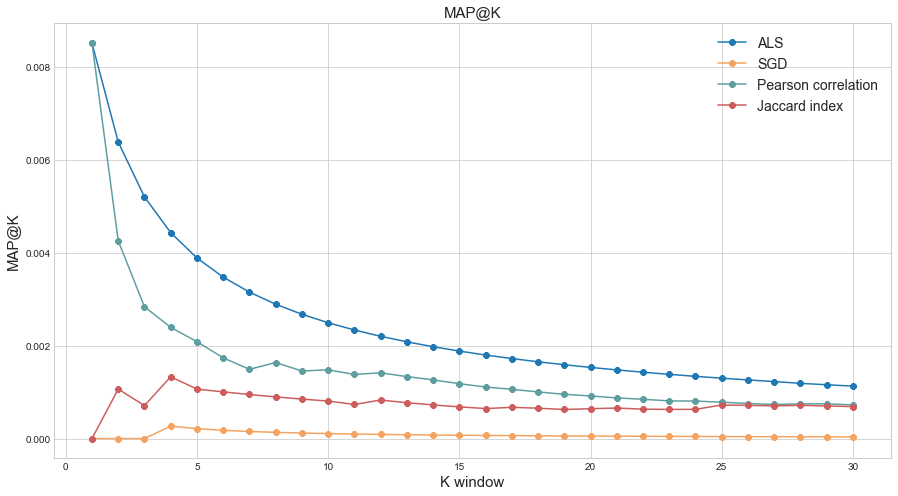

In [839]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = [15, 8])

plt.plot(list(range(1, 31)), hidden_mapk_als, marker = '8', label='ALS')
plt.plot(list(range(1, 31)), hidden_mapk_sgd, marker = '8', label='SGD', color='sandybrown')
plt.plot(list(range(1, 31)), scs_mapk_p, marker = '8', label='Pearson correlation', color='cadetblue')
plt.plot(list(range(1, 31)), scs_mapk_j, marker = '8', color='indianred', label='Jaccard index')
#plt.plot(list(range(1, 31)), mapk_rand, mark er = '8', color='indianred', label='Randomized recommendations')


plt.title('MAP@K', fontsize=15)
plt.xlabel('K window', fontsize = 15)
plt.ylabel('MAP@K', fontsize = 15)

plt.legend(fontsize=14)

(￣▽￣) / ♫ • * ¨ * • . ¸ ¸ ♪

Так как ALS модель сразу дала лучший результат, то цель из P.S. достигнута. Сейчас ночь 07.06 и у меня очень много дел впереди, так что на подбор гиперпараметров (даже на сравнительно быстром sgd) нет ни времени, ни сил. Надеюсь на понимание и хотя-бы не полное зануление этого задания.

Снизу показывается, что у ALS действительно неплохое качество в жанровой музыке.

(￣▽￣) / ♫ • * ¨ * • . ¸ ¸ ♪

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [856]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id
preds = hidden_als.Q @ hidden_als.Q[example_trackId]
preds = preds / np.sqrt((hidden_als.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(hidden_als.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.753987
9689,Bicycle Race,['Queen'],0.737942
5153,Stormbringer,['Deep Purple'],0.737942
16637,Livin' It,['Stick Figure'],0.737942
5570,Моё сердце,['Сплин'],0.731604
16224,Ты такая,"[""5'nizza""]",0.711574
13264,(Get Off Your) High Horse Lady,['Oasis'],0.703688
13263,Waiting For The Rapture,['Oasis'],0.703688
17331,"New York, New York","['Frank Sinatra', 'Tony Bennett']",0.681772


In [854]:
example_trackId = tracks_info[tracks_info.name == 'DARE'].iloc[0].id

preds = hidden_als.Q @ hidden_als.Q[example_trackId]
preds = preds / np.sqrt((hidden_als.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(hidden_als.Q[example_trackId])
similar_tracks

,name,artists,similarity
3396,DARE,['Gorillaz'],1.000000
18960,My Silver Lining,['First Aid Kit'],0.825677
4807,Genesis,['Justice'],0.811143
3479,Kids With Guns,['Gorillaz'],0.796860
6468,C.R.E.A.M. (Cash Rules Everything Around Me),['Wu-Tang Clan'],0.741246
4332,O Green World,['Gorillaz'],0.741246
15112,Будет светло,['Михаил Бублик'],0.741246
30084,Candlelight,['Khemmis'],0.741246
4325,Every Planet We Reach Is Dead,['Gorillaz'],0.741246
15930,Реальные люди,['Доминик Джокер'],0.728846


In [855]:
example_trackId = tracks_info[tracks_info.name == 'Links 2 3 4'].iloc[0].id

preds = hidden_als.Q @ hidden_als.Q[example_trackId]
preds = preds / np.sqrt((hidden_als.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(hidden_als.Q[example_trackId])
similar_tracks

,name,artists,similarity
940,Links 2 3 4,['Rammstein'],1.000000
1102,Amerika,['Rammstein'],0.920620
1105,Moskau,['Rammstein'],0.855907
37960,Unsympathetic Intellect,['Rings of Saturn'],0.851079
932,Mutter,['Rammstein'],0.847305
938,Ich Will,['Rammstein'],0.841516
58738,Screen Guru,['Young Ejecta'],0.812238
58570,Атлантида,['Воскресение'],0.812238
58571,Ветер (Дыхание доброго неба),['Воскресение'],0.812238
246,Many Men (Wish Death),['50 Cent'],0.812238
